# Preprocess the road network

In [29]:
import xml.etree.ElementTree as ET
import networkx as nx
import osmnx as ox
from shapely.geometry import LineString

tree = ET.parse('./data/network.xml')
root = tree.getroot()
nodes = root[0]
edges = root[1]

G = nx.MultiDiGraph()

def get_node_coord(node):
    return (node['x'], node['y'])

def get_line_between_nodes(n1, n2):
    coord1 = get_node_coord(n1)
    coord2 = get_node_coord(n2)
    return LineString([coord1, coord2])

for node in nodes:
    n = node.attrib
    node_id = int(n['id'])
    node_x = float(n['x'])
    node_y = float(n['y'])
    G.add_node(node_id, x=node_x, y=node_y, osmid=node_id)

for edge in edges:
    
    e = edge.attrib
    
    # Convert the variables into correct types
    e['id'] = int(e['id'])
    e['from'] = int(e['from'])
    e['to'] = int(e['to'])
    e['length'] = float(e['length'])
    e['freespeed'] = float(e['freespeed'])
    e['capacity'] = float(e['capacity'])
    e['permlanes'] = float(e['permlanes'])
    e['oneway'] = int(e['oneway'])
    
    # Add a shape field for plotting. Shape is assumed to be a straight 
    # line connecting the end points
    start = float(e['from'])
    end = float(e['to'])
    e['shape'] = get_line_between_nodes(G.node[start], G.node[end])
    
    # Add the edge to the graph
    G.add_edge(e['from'], e['to'], key=0, **e)

G.graph['crs'] = {'datum': 'WGS84',
  'ellps': 'WGS84',
  'proj': 'utm',
  'zone': 35,
  'units': 'm'}
G.graph['name'] = 'SF'

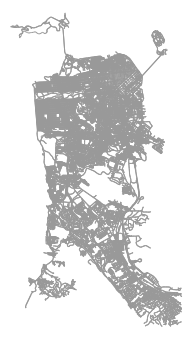

(<Figure size 229.607x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f82888952b0>)

In [2]:
nc = ['white' for node in G.nodes]
ox.plot_graph(G, node_color=nc)

# Preprocess the demand

In [4]:
tree = ET.parse('./data/population.xml')

root = tree.getroot()

demands = root.getchildren()

num_demands = len(demands)

edge_id_to_ind = {}
for i, e in enumerate(G.edges):
    edge_id_to_ind[G.edges[e]['id']] = i

od_pairs = {}

for d in demands:
    orig = int(d[0][0].attrib['link'])
    dest = int(d[0][2].attrib['link'])
    key = (orig,dest)
    if key in od_pairs:
        od_pairs[key] += 1
    else:
        od_pairs[key] = 1
    time = d[0][1].attrib['mode'] == 'dep_time'

origs = []
dests = []
rates = []
edges = list(G.edges)
for o, d in od_pairs:
    try:
        o_ind = edge_id_to_ind[o]
        d_ind = edge_id_to_ind[d]
    except:
        print('cannot match od pair to nodes in the network')
        continue
    
    o_node = edges[o_ind][0]
    d_node = edges[d_ind][0]
    if d_node == o_node:
        d_node = edges[d_ind][1]
    
    origs.append(o_node)
    dests.append(d_node)
    
    rate = od_pairs[(o, d)] / 24
    rates.append(rate)

d = Demand(origs, dests, rates)